This code illustrates the basic functionality of the component model using the data from this paper:

Norman-Haignere SV, Kanwisher NG, McDermott JH (2015). Distinct cortical pathways for music and speech revealed by hypothesis free voxel decomposition. Neuron.

In [111]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pyrsa

from importlib import reload  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Create sound x voxel dataset. There are 165 sounds and 11065 voxels concatenated across 10 subjects.

In [112]:
D = io.matlab.loadmat('165soundData/simple_data_matrix_Neuron2015.mat', variable_names=['D'])['D']
D_average_reps = np.nanmean(D, axis=2)
dataset = pyrsa.data.Dataset(D_average_reps)

Stimuli have been ordered by category. Sounds and categories shown below.

In [113]:
category_labels = io.matlab.loadmat('165soundData/simple_data_matrix_Neuron2015.mat', 
                                    variable_names=['category_labels'])['category_labels'].squeeze()
stim_names = io.matlab.loadmat('165soundData/simple_data_matrix_Neuron2015.mat', 
                               variable_names=['stim_names'])['stim_names'].squeeze()
for i in range(len(category_labels)):
    print("stim {index}: {name}, {category}".format(
        index=i, name=stim_names[i][0], category=category_labels[i][0]))

stim 0: stim28_big_band_music, Music
stim 1: stim33_bluegrass, Music
stim 2: stim34_blues_band, Music
stim 3: stim136_drum_roll, Music
stim 4: stim183_guitar, Music
stim 5: stim254_orchestra_music, Music
stim 6: stim296_rock_guitar_solo, Music
stim 7: stim315_saxophone_jazz_solo, Music
stim 8: stim360_cymbal_crash, Music
stim 9: stim384_trumpet_jazz_solo, Music
stim 10: stim394_violin, Music
stim 11: stim19_electric_bass, Music
stim 12: stim72_cello, Music
stim 13: stim137_drum_solo, Music
stim 14: stim268_piano, Music
stim 15: stim484_soundtrack_for_a_sad_movie_scene, Music
stim 16: stim517_soundtrack_from_an_action_scene, Music
stim 17: stim461_latin_music, Music
stim 18: stim365_techno, Music
stim 19: stim490_soundtrack_from_a_western, Music
stim 20: stim393_video_game_music, Music
stim 21: stim317_horror_film_sound_effects, Music
stim 22: stim82_church_bells, Music
stim 23: stim524_cartoon_sound_effects, Music
stim 24: stim92_country_song, Song
stim 25: stim434_classic_rock, Song
s

Plot RDM of overall dataset

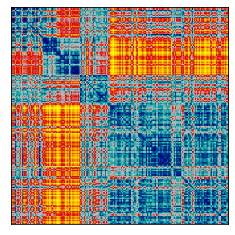

In [114]:
data_rdm = pyrsa.rdm.calc_rdm(dataset)
pyrsa.vis.show_rdm(data_rdm, do_rank_transform=True)

Load components from paper, and show RDM implied by these components.

They are clearly very similar. The correlation is 0.978.

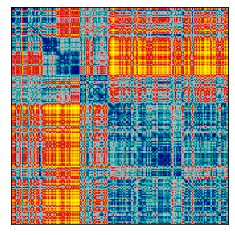

Correlation with data RDM: [[0.9782896]]


In [115]:
R = io.loadmat(MAT_file, variable_names=['R'])['R']
W = io.loadmat(MAT_file, variable_names=['W'])['W']
neuron2015_components = pyrsa.data.Components(R=R, W=W)
component_rdm = pyrsa.rdm.calc_rdm(pyrsa.data.Dataset(neuron2015_components.reconstruct()))
pyrsa.vis.show_rdm(component_rdm, do_rank_transform=True)

r = pyrsa.rdm.compare(data_rdm, component_rdm, method='corr')
print('Correlation with data RDM:', r)

Show RDM implied by individual components. The components are given coarse names based on their response selectivity:

C1: Responds selectively to low-frequency sounds with weights concentrated in low-frequency tonotopic region of primary auditory cortex

C2: Responds selectively to high-frequency sounds with weights concentrated in high-frequency tonotopic region of primary auditory cortex

C3: Responds to a diverse set of environmental sounds. Straddles primary/non-primary regions.

C4: Responds selectively to tonal sounds with pitch. Mostly located in between primary/non-primary regions.

C5: Responds selectively to speech. Located in lateral non-primary auditory cortex.

C6: Responds selectively to music. Located in anterior/posterior non-primary auditory cortex.

C1: lowfreq


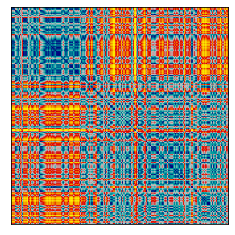

C2: highfreq


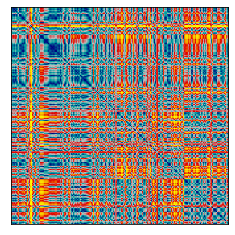

C3: envsounds


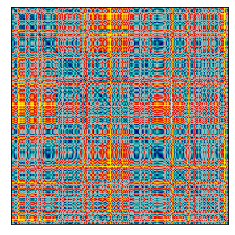

C4: pitch


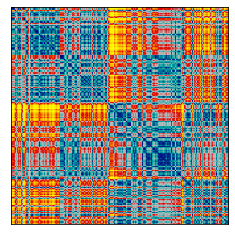

C5: speech


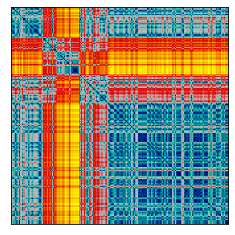

C6: music


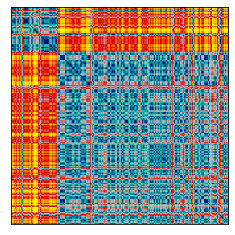

In [116]:
component_names = io.loadmat(MAT_file, variable_names=['component_names'])['component_names'].squeeze()

for i in range(len(component_names)):
    print('C' + str(i+1) + ':', component_names[i][0])
    component_rdm = pyrsa.rdm.calc_rdm(pyrsa.data.Dataset(neuron2015_components.reconstruct(subset=[i])))
    pyrsa.vis.show_rdm(component_rdm, do_rank_transform=True)

Show component RDMs separately for primary and non-primary components, leaving out C3 which is ambiguous.

Note how music and speech (first two blocks) are only clearly distinct in non-primary regions, due to their coarsely similar acoustics.

Primary


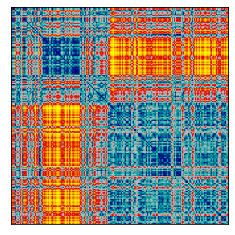

Nonprimary


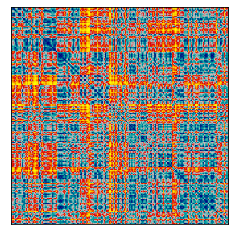

In [117]:
print('Primary')
component_rdm = pyrsa.rdm.calc_rdm(pyrsa.data.Dataset(neuron2015_components.reconstruct(subset=[0,1,3])))
pyrsa.vis.show_rdm(component_rdm, do_rank_transform=True)

print('Nonprimary')
component_rdm = pyrsa.rdm.calc_rdm(pyrsa.data.Dataset(neuron2015_components.reconstruct(subset=[4,5]))) # without ambiguous C3
pyrsa.vis.show_rdm(component_rdm, do_rank_transform=True)

Show how RDM develops as you add PCs.

This code is the first to actually compute components from data. 

Only need 3 PCs to capture RDMs. Note that the top 3 PCs almost certainly contains partial contributions from each of the 6 components from the paper. Despite the fact that the top 3 PCs capture the RDM well, additional components clearly lead to better cross-validated prediction accuracy up to the 6th component (see paper).

Dataset RDM


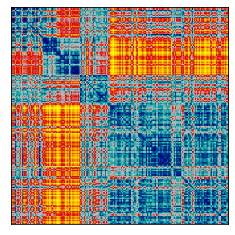

Number of PCs: 1


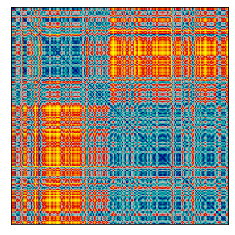

Correlation with data RDM: [[0.90442713]]
Number of PCs: 2


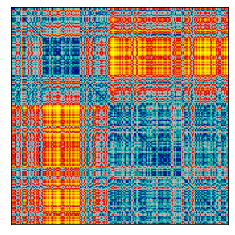

Correlation with data RDM: [[0.97547541]]
Number of PCs: 3


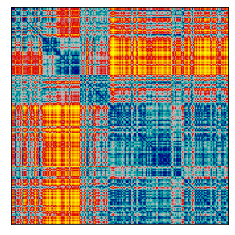

Correlation with data RDM: [[0.99300364]]
Number of PCs: 4


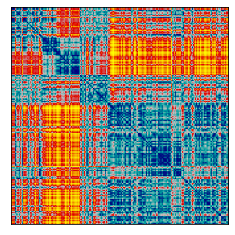

Correlation with data RDM: [[0.99613456]]
Number of PCs: 5


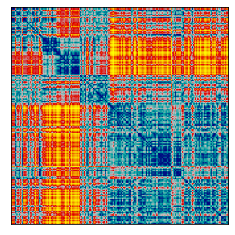

Correlation with data RDM: [[0.99680633]]
Number of PCs: 6


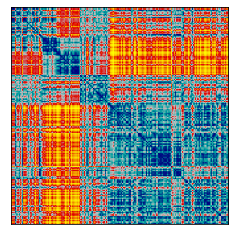

Correlation with data RDM: [[0.99742698]]


In [118]:
print('Dataset RDM')
pyrsa.vis.show_rdm(data_rdm, do_rank_transform=True)

pca_components = pyrsa.data.Components() # Empty component object
pca_components.pca(dataset.measurements) # Fill with PCs
for n_components in np.arange(1, 7):
    print('Number of PCs:', n_components)
    recon = pca_components.reconstruct(subset=np.arange(0, n_components)) # reconstruct with top N PCs
    component_rdm = pyrsa.rdm.calc_rdm(pyrsa.data.Dataset(recon))
    pyrsa.vis.show_rdm(component_rdm, do_rank_transform=True)
    
    r = pyrsa.rdm.compare(data_rdm, component_rdm, method='corr')
    print('Correlation with data RDM:', r)

Infer similar components with FastICA.

Method in the Neuron paper directly maximes entropy using a histogram-based method, which is suitable for fMRI where you have many voxels and can accurately estimate entropy for one-dimensional projections. FastICA uses a coarser approximation based on moments. Note that unlike PCA, ICA finds a local optimum and the results can thus depend upon the seed. Ideally, one runs the algorithm many times and tests whether the solutions with lowest cost all form a coherent solution.

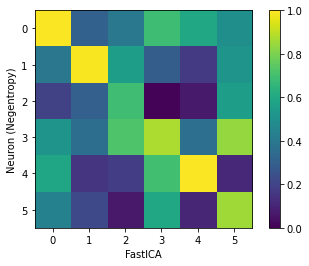

In [119]:
import scipy.optimize
def matching_order(ref_matrix, permute_matrix):
    '''Use Hungarian algorithm to match-up components.'''
    
    corrmat = corr_col_pairs(ref_matrix, permute_matrix)
    fixed_row_order, permuted_col_order = scipy.optimize.linear_sum_assignment(1-np.abs(corrmat))
    return permuted_col_order

def corr_col_pairs(A, B):
    '''Correlates columns of A and B. 
    
    Less annoying than using np.corrcoef on the matrices.
    '''
        
    corrmat = np.zeros((A.shape[1], B.shape[1]))
    for i in range(A.shape[1]):
        for j in range(B.shape[1]):
            corrmat[i,j] = np.corrcoef(A[:,i], B[:,j], rowvar=False)[0,1]
            
    return corrmat

# ICA component
# Try a few seeds to examine dependence
random_seed = 0
fastica_components = pyrsa.data.Components()
fastica_components.fastica(dataset.measurements, n_components=6, method_params={'random_state': random_seed})

# Order components to best match neuron paper
optimal_order = matching_order(neuron2015_components.R, fastica_components.R)
fastica_components.order_components(optimal_order) 

# Compare
corrmat = corr_col_pairs(neuron2015_components.R, fastica_components.R)
plt.imshow(np.abs(corrmat), vmin=0, vmax=1)
plt.xlabel('FastICA')
plt.ylabel('Neuron (Negentropy)')
plt.colorbar()
plt.show()

PCA components are quite different due to orthogonality constraint

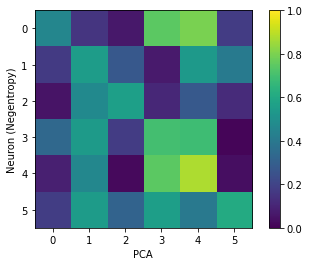

In [120]:
# Order components to best match neuron paper
optimal_order = matching_order(neuron2015_components.R, pca_components.R)
pca_components.order_components(optimal_order) 

# Compare
corrmat = corr_col_pairs(neuron2015_components.R, pca_components.R)
plt.imshow(np.abs(corrmat), vmin=0, vmax=1)
plt.xlabel('PCA')
plt.ylabel('Neuron (Negentropy)')
plt.colorbar()
plt.show()